# PyTorch WorkFlow

1. Data(prepare and load)
2. Build model - Choose loss function, optimizer, training loop
3. Fitting the model to the data
4. Making predictions and evaluating a model
5. Saving and loading a model
6. Putting it all together

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.10.2'

We'll get a hold of this workflow by doing this for predicting a straight line.

## Data (preparing and loading)

Let's create some data with `linear regression` and then use PyTorch to see if we can build a model to estimate these parameters using `gradient descent`.

In [ ]:
# Parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [ ]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Nice!! Let's go and create a model that can learn the relationship between features and labels

### Splitting the data

In [ ]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

The model will train on train data and evaluated on test data.

Let's plot the data to see how it looks.

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  plots training data, test data and compares predictions
  """

  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="preditions")

  plt.legend(prop={"size": 14})

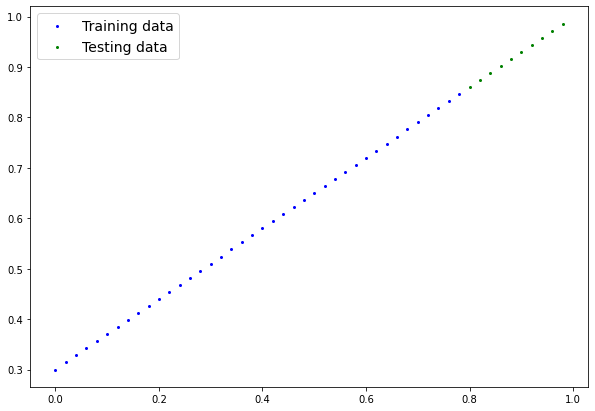

In [ ]:
plot_predictions()

Wow!! That looks good and makes sense too.

## 2. Build model

Let's replicate a standard linear regression model using pytorch.

In [ ]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module): # almost everyting in PyTorch is a nn.module(this is a neural network lego block)
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # Start with random weights and get's adjusted as model learns
                                            requires_grad=True, # Update this value with gradient?
                                            dtype=torch.float # PyTorch uses float32 by default
                                            ))
    
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float
                                         ))
    
  # Forward pass -> Computation in the model
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

### PyTorch Model building essentials

PyTorch has four (give or take) essential modules that can be used to create almost any kind of neural netwoork.

They are `torch.nn`, `torch.optim`, `torch.data.Dataset` and `torch.data.Dataloader`. For now, let's focus on the first two and get to the other two later.

|Module|What id does|
|------|------------|
|`torch.nn`| Contains all of the building blocks for computaional graphs(essentially a series of computations executed in a particulay way)|
|`torch.nn.Parameter`| Stores torch tensors that can be used with `nn.Module`, <br />if requires_grad=True is set then the gradient calculauation are done automatically for this parameter. <br />This is called as autograd|
|`torch.nn.Module`| The base class for all neural network modules, all the building block for neural networks are subclasses. <br />To build a neural network in PyTorch, the model should be a subclass and requires a `forward()` method to be implemented|
|`torch.optim`| Contains various optimization algorithms on how to chane `nn.Parameter` to reduce loss|
|`def forward()`| All `nn.Module` subclass requires this method and defines the computations that will take place on the data passed to the particular `nn.Module`|

### Checking the contents of a PyTorch Model

Now we've gone through the explainations of bb's let's create a model from the LinearRegression class and check it's parameters using `.parameters()`

In [ ]:
# set manaul seed since nn.Parameter are randomnly initialized
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

#  chek the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model contains) using `
.state_dict()`

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Right now the parameters are randomnly intialized because of torch.randn() and these should be learned by the model and come close to hardcoded weights and bias.

### Making predcition using `torch.inference_mode()`

Because our model starts with random values, right now they'll have poor preditive power.

Let's test this out:

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

In [ ]:
# Let's see howthe predictions looks like
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values: {y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values: tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


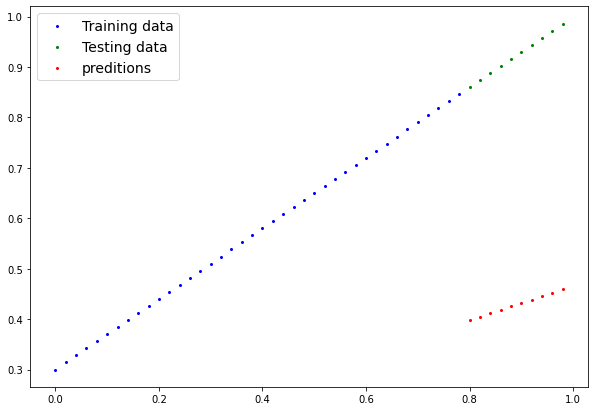

In [ ]:
# Let's plot the predictions
plot_predictions(predictions=y_preds)

In [ ]:
y_test-y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

These predictions looks pretty bad, This makes sense as the model has yet to take a look at train data(blue dots) and just predicts with randomly initiated weights and bias(params)

Let's change that.

## 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing(randomly).

Let's write code to see if the model can try and figure them out myself.

### Creating a loss function and optimizer in PyTorch

For our model to update its parameters on its own, we'll add **loss function** as well as an **optimizer**.

* **Loss function** - Measures how wrong your models predictions are compared to the truth labels. Lower the better. PyTorch has plenty of built-in loss functions in `torch.nn`

* **Optimizer** - Tells how the model to update its internal parameters to best lower the loss. Optimizer function implementations in `torch.optim`

Since we're predicting a number, let's use MAE(which is under torch.nn.L1Loss()) in PyTorch as our loss function.

Mean absolute error(MAE, in PyTorch: `torch.nn.L1Loss`) measures the absolute difference between two points(predictions and labels) and then takes mean across all examples.

And use `torch.optim.SGD(params,lr)` where:

* `params` is the target model parameters to optimize(e.g weights and bias values we randomly set before)

* `lr` is the Learning rate to update the paramters at, higher means optimizer will try larger updates and lower means smaller updates.

In [ ]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.01
)

### Creating an optimization loop in PyTorch

Now we've a loss function and an optimizer, let's create a **raining loop** and **testing loop**.

The training loop involves the model going through the training data and learning relationships between the `features` and `labels`.

The testing involves going through the testing data and evaluating how good the patters are that the model learned on the training data.

In [ ]:
torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  # Training

  # Put model in training mode(this is the default state of the model)
  model_0.train()

  # 1. Forward pass on train data using the forward() method inside
  y_pred = model_0(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad the optimizer
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Progress the optimizer
  optimizer.step()

  ### Testing

  # Put the model in evaluation mode
  model_0.eval()

  with torch.inference_mode():
    # 1. Forward pass on test_data
    test_pred = model_0(X_test)

    # 2. Calculate loss on test data
    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    # Print out what's happening
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819


Looks like loss is going down with every epoch, let's plot it to find out:

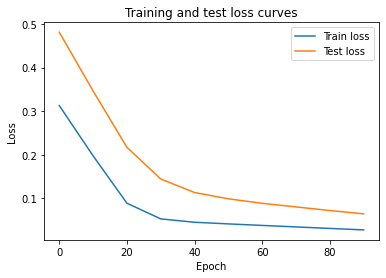

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show();

Now the **loss curves** are going down, why because we're performing backpropogation from forward pass(loss calulations) using loss.backwards() to the starting point of forward pass and calculating the gradient for the weight and bias. Then optimizer uses this to step in the direction opposite of gradient to reduce the loss and updated the weight and bias with x time learning rate.

Let's inspect our model's `.state_dict()` to see how close our model gets to the original values we set for weights and bias.

In [ ]:
# Find model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weight and bias are:")
print(f"Weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weight and bias are:
Weights: 0.7, bias: 0.3


Look at that model has learned and leaned closer to actual values of params, let's train this for 200 epochs and see how close it gets:

In [ ]:
torch.manual_seed(42)

# Set the number of epochs for model to train
epochs = 200

# Loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

  ### Training

  # Put the model in training model
  model_0.train()

  # 1. Calculate the forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad optimizer
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Progress the optimizer(gradient descent)
  optimizer.step()

  ### Testing

  # put the model in eval mode
  model_0.eval()

  with torch.inference_mode():

    # 1. Forward pass on test data
    test_pred = model_0(X_test)

    # 2. Calculate loss on test data
    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    # Print what's happening
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 10 | MAE Train Loss: 0.021020207554101944 | MAE Test Loss: 0.04819049686193466 
Epoch: 20 | MAE Train Loss: 0.01758546568453312 | MAE Test Loss: 0.04060482233762741 
Epoch: 30 | MAE Train Loss: 0.014155393466353416 | MAE Test Loss: 0.03233227878808975 
Epoch: 40 | MAE Train Loss: 0.010716589167714119 | MAE Test Loss: 0.024059748277068138 
Epoch: 50 | MAE Train Loss: 0.0072835334576666355 | MAE Test Loss: 0.016474086791276932 
Epoch: 60 | MAE Train Loss: 0.0038517764769494534 | MAE Test Loss: 0.008201557211577892 
Epoch: 70 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 80 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 90 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 100 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 110 | MAE Train Loss: 0.0089

In [ ]:
200 % 20

0

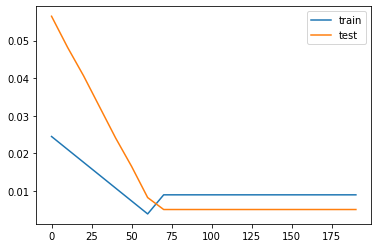

In [ ]:
# Plotting the loss for 200 epochs
plt.plot(epoch_count, train_loss_values, label="train")
plt.plot(epoch_count, test_loss_values, label="test")
plt.legend();

In [ ]:
# Find model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weight and bias are:")
print(f"Weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

And the original values for weight and bias are:
Weights: 0.7, bias: 0.3


Ah that's good

## 4. Making predictions with a trained PyTorch Model

Now we've got a trained model, let's make some predictions with it:

There are three things to remember when making predictions(also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode(`model.eval()`)
2. Make predictions using the inference mode context manager(`with torch.inference_mode()`)
3. All predictions should be made with objects on the same device(e.g. data and model on GPU only or data and model on CPU only)

First two makes sure all helpful calculations and setting PyTorch uses behind the scenes during training but aren't necessay for inference re turned off(resulting in faster computation). And the third ensures not running into cross-device errors.

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

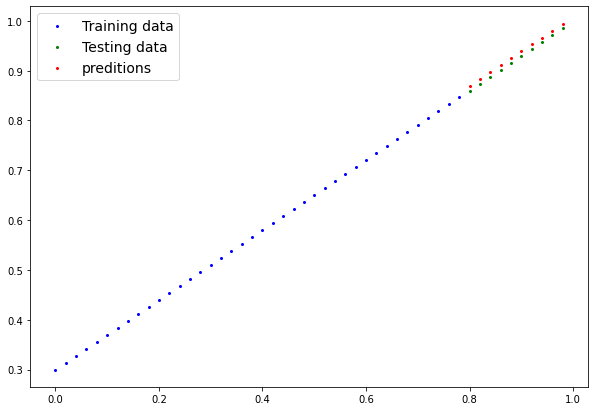

In [ ]:
# LEt's plot the predictions
plot_predictions(predictions=y_preds)

The predictions(red dots) looking far closer than before!

## 5. Saving and loading a PyTorch model

To use the model outside a notebook in an application or something else. we need to save the model.

For saving models in PyTorch, there are three main methods 

1. `torch.save` - Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other python objects like dictionaries can be saved using `torch.save`

2. `torch.load` - Uses pickles unpickling features to deserialize and load pickled python object files into memory

3. `torch.nn.Module.load_state_dict` - Loads a models parameter dictionary using a saved `state_dict()` object



### Saving a PyTorch model's `state_dict()`

Recommended way for saving and loading a model for inference (making prediction) is by saving and loading a model's `state_dict()`

Steps to do that:

1. Create a directory for saving `models` using Python's `pathlib` module

2. Create a file path to save the model to

3. Call `torch.save(obj, f)` where obj is target model's state_dict and f is the filename of where to save the model.

In [ ]:
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/workflow_model.pth


### Loading a saved PyTorch model's state_dict()

In [ ]:
# 1. Create a new instance of our model
loaded_model_0 = LinearRegressionModel() # Instantiated with random weights

# 2. Load the state_dict(weights) of saved model
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
# Make some inference with loaded model
loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

In [ ]:
loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's do all the steps in the workflow and make our code device agnostic

In [ ]:
# Import Pytorch and matplotlib
import torch
from torch import nn 
import matplotlib.pyplot as plt

torch.__version__

'1.12.0+cu113'

In [ ]:
# Let's make the code agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [ ]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (Features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)

y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Let's split the data

In [ ]:
# Split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

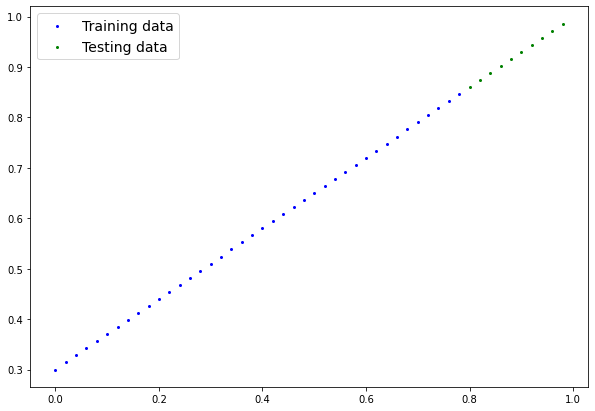

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch linear model

We've got some data, now it's time to make a model.

We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using `nn.Parameter()` we'll use `nn.Linear(in_features, out_features)` to do it for us.

In [ ]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set manaul seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check model's current device
next(model_1.parameters()).device

device(type='cpu')

Looks like model's on CPU by default
Let's change it to be in GPU (if it's available)

In [ ]:
model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

Time to build a training and testing loop. 

First we'll need an loss function and optimizer

In [ ]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.01
)

Nice! We've already put our model in GPU , let's do the same with data.

In [ ]:
torch.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):

  ### Training
  model_1.train()

  # 1. Forward pass
  y_preds = model_1(X_train)

  # 2. Loss
  loss = loss_fn(y_preds, y_train)

  # 3. Reset optimizer gradient
  optimizer.zero_grad()

  # 4. Backward propogation
  loss.backward()

  # 5. Optimizr step
  optimizer.step()

  ### Testing

  model_1.eval()

  with torch.inference_mode():
    test_preds = model_1(X_test)

    test_loss = loss_fn(test_preds, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Train loss: 0.5436570048332214 | Test loss: 0.560505211353302
Epoch: 100 | Train loss: 0.005878167692571878 | Test loss: 0.012984705157577991
Epoch: 200 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 300 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 400 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 500 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 600 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 700 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 800 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523
Epoch: 900 | Train loss: 0.010256479494273663 | Test loss: 0.00033081771107390523


In [ ]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2925], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3
